
# Tagging

We want to extract common semantic themes from common words we may see in fantasy role playing games. These themes ('tags') could be able to identify groups.

For example, for `Infernal sword`, we might consider extracting the `weapon` tag and the `fire` tag (or possibly `demon`, `unholy`).

Many games, like Pathfinder, do provide some degree of tag metadata (for example, 'traits'), but these are often directly related to the mechanics rather than the semantic context of the item (or if they are semantic, they are usually surface level, such as a `Draugr` having the `water` trait).

In addition, these tags may not necessarily correspond to the definition of the word. Consider this example:

`Axe of the God King: An hallowed weapon, forged in the heart of a star, said to immolate its victims in divine furious fire`. 

Some obvious tags we may extract include: 
- `weapon` 
- `divine` 
- `holy`
- `fire`

However, what other metacontextual information can we extract? We can imagine:

- `cosmos` - perhaps this weapon might be used by folks with access to space weaponry?
- `retribution` - this is an axe wielding the power of the vengeance of a god
- `legendary` - legends have sprung around this item, which is "said to" immolate its victims.
- `Paladin` - This is a step further removed, but we might imagine a paladin to use divinely retributive weapons to smite their enemies.

Ideally, someone filtering over these tags would be able to find these weapons. We might imagine this showing up in a random pool for:
- A mysterious shopkeeper who claims to be from the stars themselves.
- The weapon carried by a fallen angel of the god of fire.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import cluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

import spacy # if this gives an error, downgrade to python 3.12.3
nlp = spacy.load("en_core_web_lg")

from tqdm import tqdm
tqdm.pandas()

In [16]:
# Extract word vectors from a list of noun chunks
# Returns a dictionary mapping words to their index in the matrix, and the matrix itself
def extract_vectors(noun_chunks):
    word_vectors = {}
    # set as upper bounds (assuming no duplicates)
    word_vector_matrix = np.zeros(shape=(len(noun_chunks), 300))

    #TODO: rewrite to be pythonic
    i = 0
    for word in noun_chunks:
        if word.text in word_vectors:
            continue
        word_vector_matrix[i,:] = word.vector
        word_vectors[word.text] = i
        i = i + 1

    word_vector_matrix = word_vector_matrix[:i,:]
    
    return word_vectors, word_vector_matrix


# Load sample words
sample_words = pd.read_json("res/example_word_list.json")[0].to_list()
sample_words = [nlp(x).noun_chunks for x in sample_words]
sample_words = [x for xs in sample_words for x in xs]

# Extract word vectors from words
wv_mapping, wv_matrix = extract_vectors(sample_words)
reverse_wv_mapping = {v: k for k, v in wv_mapping.items()}

['Red dragon', 'Blue dragon', 'Gold dragon', 'Silver dragon', 'Magma dragon', 'Shadow dragon', 'Dark dragon', 'Black ogre', 'Red ogre', 'Orange ogre', 'Blue ogre', 'Storm giant', 'Cloud giant', 'Moon giant', 'Water yai', 'Fire yai', 'Flaming sword', 'Sword of night', 'Rusting sword', 'Molten sword', 'Halberd of lightning', 'Giant axe', 'Flaming arch', 'Fireball', 'Lightning bolt', 'Shadowball', 'Ocean devil', 'Infernal devil']


In [25]:
# Attempt agglomerative clustering
model = AgglomerativeClustering(n_clusters = None, distance_threshold = 60, linkage = 'ward')
y = model.fit_predict(wv_matrix)

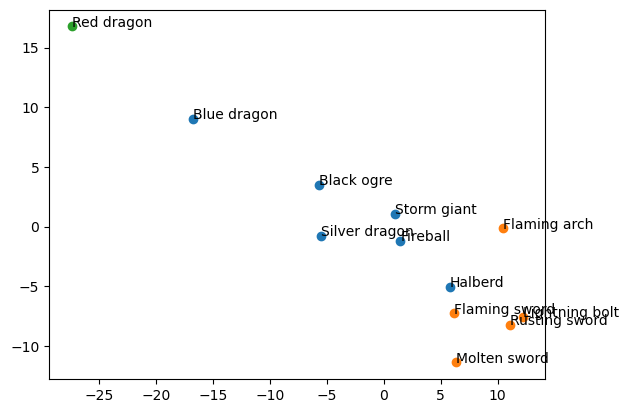

Number of clusters: 4
Number of words: 30
Average words per cluster:  7.5


In [31]:
display_frac = 0.4

# visualization
rows, shapes = wv_matrix.shape
display_rows = int(rows * display_frac)

# use PCA (not for clustering, just dim reduction)
pca = PCA(n_components=2)
reduced_wv_matrix = pca.fit_transform(wv_matrix)

disp = np.random.choice(np.arange(0,reduced_wv_matrix.shape[0]), size=display_rows, replace = False)
disp_values = reduced_wv_matrix[disp]
disp_clusters = y[disp]
disp_names = np.array([name for name in reverse_wv_mapping.values()])[disp]

# plot
fig, ax = plt.subplots()
for unique_y in np.unique(disp_clusters):
    disp_x = disp_values[disp_clusters == unique_y,0]
    disp_y = disp_values[disp_clusters == unique_y,1]
    ax.scatter(disp_x, disp_y)
    for i, txt in enumerate(disp_names[disp_clusters == unique_y]):
        ax.annotate(txt, (disp_x[i], disp_y[i]))

plt.show()

unique, counts = np.unique(y, return_counts=True)
print(f'Number of clusters: {len(unique)}')
print(f'Number of words: {len(sample_words)}')
print('Average words per cluster: ', np.mean(counts))

Issues:

- It seems to work, but there should be multiple types of clusters for different parts of things

![alt text](res/afc1891f-d610-406e-85d1-bc5b552868cd.png)


- For example: *blue dragon*- should this go into 'blue' or 'dragon'?
- Similarly, for stuff like *giant sword*- this is even more ambiguous. Should it go into giant, or sword? Should giant be a noun or an adjective (it can be both here, as 'sword belonging to the giants' or 'sword that is physically large')

In [ ]:
# TODO:
# - check other columns of items/spells (ie 'onset' for damage type, 'trigger', etc)
# - creature. maybe should include: immunity? resistance? weakness? skill? alignment?
# - spell. target? (seems to be able to be 'one undead' etc)
# - creature's spells? should these be included?
# -